# CNN
Convolutional neural network model for artist recognizeing by paiting

In [27]:
# uncomment the following line if you are running this notebook on Google Colab
# this will install the most recent version of TensorFlow and Keras 3
# !pip install tensorflow --upgrade

In [28]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [29]:
import keras
print(keras.__version__)

3.6.0


In [30]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score

## Load Dataset

In [31]:
# uncomment the following line to prevent some possible errors
# !pip install --upgrade --no-cache-dir gdown

In [32]:
# uncomment the following line to download the dataset if you haven't already
# !gdown 1-0d315aj7Ai8NNqat65XDvaOcHDcHiUD

In [33]:
# uncomment the following line to unzip the dataset if you didn't do it before
# !unzip famous_paintings.zip > /dev/null 2>&1

## Searching Dataset

In [34]:
# dir_name = 'data/*'
# files = glob.glob(dir_name)
# df_train = pd.DataFrame({'full_path': files})
# file_name = df_train['full_path'].str.split("data").str[1]
# painters = file_name.str.rsplit('_',1).str[0]
# df_train['painter'] = painters
# df_train.head()




dir_name = 'data\*'
files = glob.glob(dir_name)
df_train = pd.DataFrame({'full_path': files})
modified_string = lambda x: ''.join([i for i in x if not i.isdigit()])
export_name = np.vectorize(lambda x: x[len("data") + 1:-4])
remove_digit = np.vectorize(lambda x: ''.join([i for i in x if not i.isdigit()]))
remove_underline = np.vectorize(lambda x: x[:-1])
painters = export_name(df_train["full_path"])
painters = remove_digit(painters)
painters = remove_underline(painters)
df_train['painter'] = painters
df_train

,full_path,painter
0,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer
1,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer
2,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer
3,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer
4,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer
...,...,...
6511,D:\Quera college Deep learning and Neural netw...,Vincent_van_Gogh
6512,D:\Quera college Deep learning and Neural netw...,Vincent_van_Gogh
6513,D:\Quera college Deep learning and Neural netw...,Vincent_van_Gogh
6514,D:\Quera college Deep learning and Neural netw...,Vincent_van_Gogh


In [35]:
# get the list of unique painters in the dataset
class_names = df_train.painter.unique()
print(class_names)

['Albrecht_Durer' 'Alfred_Sisley' 'Amedeo_Modigliani' 'Andy_Warhol'
 'Edgar_Degas' 'Francisco_Goya' 'Frida_Kahlo' 'Henri_Matisse'
 'Hieronymus_Bosch' 'Kazimir_Malevich' 'Leonardo_da_Vinci' 'Marc_Chagall'
 'Mikhail_Vrubel' 'Pablo_Picasso' 'Paul_Gauguin' 'Paul_Klee'
 'Peter_Paul_Rubens' 'Pierre-Auguste_Renoir' 'Pieter_Bruegel' 'Rembrandt'
 'Rene_Magritte' 'Salvador_Dali' 'Sandro_Botticelli' 'Titian'
 'Vincent_van_Gogh']


### Some paintings

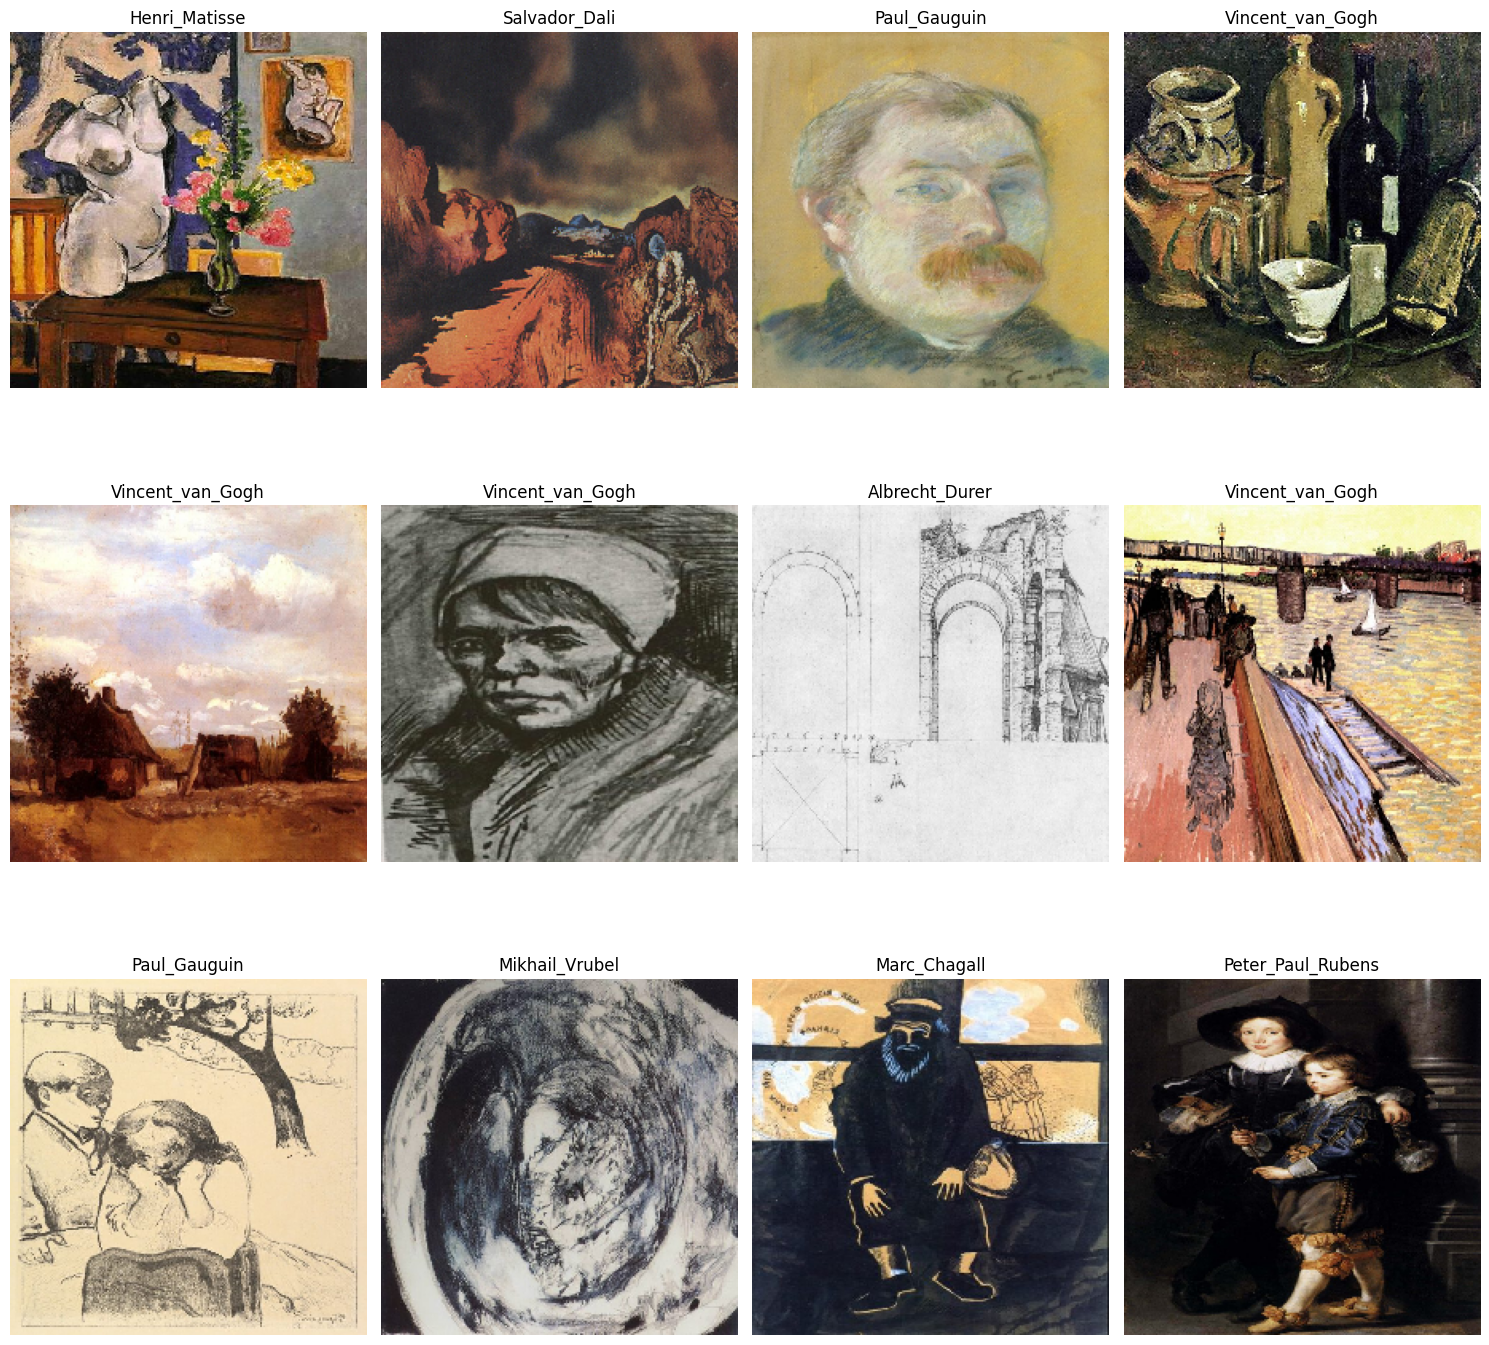

In [36]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
random_indices = np.random.choice(df_train.index, size=12, replace=False)
for i, ax in zip(random_indices, axes.flatten()):
    img = keras.preprocessing.image.load_img(df_train.full_path[i], target_size=(224, 224))
    ax.imshow(img)
    ax.set_title(df_train.painter[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train.painter)
df_train.head()

,full_path,painter,label
0,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer,0
1,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer,0
2,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer,0
3,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer,0
4,D:\Quera college Deep learning and Neural netw...,Albrecht_Durer,0


In [38]:
print(df_train['label'].unique().min())
print(df_train['label'].unique().max())

0
24


In [39]:
import shutil

# create a folder for each label
for label in df_train.label.unique():
    os.makedirs(f'data/{label}', exist_ok=True)

# move each image to its corresponding label folder
for i, row in df_train.iterrows():
    shutil.move(row.full_path, f'data/{row.label}')

## Reading images

In [40]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = len(class_names)

In [41]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory='./data/',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# find the class names so in prediction time we can map the predictions to the painters properly
class_names = train_dataset.class_names
print('Class names:', class_names)

val_dataset = image_dataset_from_directory(
    directory='./data/',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 6516 files belonging to 25 classes.
Using 5213 files for training.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '3', '4', '5', '6', '7', '8', '9']
Found 6516 files belonging to 25 classes.
Using 1303 files for validation.


## Preprocessing

In [42]:
from keras.applications.resnet50 import preprocess_input

# Preprocess the data
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

## Creating model using Resnet50

In [43]:
import plotly.express as px

# metric: 'accuracy' or 'loss'
def display_curves(history, metric):
  df = pd.DataFrame(history.history[metric], columns=[metric])
  df['val_'+metric] = history.history['val_'+metric]
  fig = px.line(df, x= df.index+1, y= [metric, 'val_'+metric])
  fig.update_layout(xaxis_title='Epochs', yaxis_title=metric)
  fig.show()

In [46]:
model2 = keras.applications.ResNet50(input_shape= IMAGE_SIZE + (3,),
                                     weights= 'imagenet',
                                     include_top= False,
                                     pooling= 'avg')
model2.trainable = False
x = keras.layers.Flatten()(model2.output)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model2 = keras.models.Model(model2.input, x)

In [47]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,649,625 (94.03 MB)

 Trainable params: 1,061,913 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
model2.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint("model2.keras", save_best_only=True, monitor="val_loss")
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

EPOCHS = 15
history2 = model2.fit(train_dataset,
                     validation_data = val_dataset,
                     epochs = EPOCHS,
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.4103 - loss: 2.1934 - val_accuracy: 0.8066 - val_loss: 0.6855
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.7567 - loss: 0.8264 - val_accuracy: 0.7866 - val_loss: 0.6757
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.8261 - loss: 0.5638 - val_accuracy: 0.8480 - val_loss: 0.5079
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.8673 - loss: 0.4064 - val_accuracy: 0.9002 - val_loss: 0.3489
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.9132 - loss: 0.2790 - val_accuracy: 0.9179 - val_loss: 0.3058
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.9328 - loss: 0.2206 - val_accuracy: 0.9486 - val_loss: 0.2139
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.9584 - loss: 0.1565 - val_accuracy: 0.9455 - val_loss: 0.2251
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9611 - loss: 0.1268 - val_accuracy: 0.9517 - v

In [49]:
display_curves(history2, 'loss')

In [50]:
display_curves(history2, 'accuracy')

## Validation

In [51]:
best_model = keras.models.load_model("model2.keras")
best_model.evaluate(val_dataset)

21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.9763 - loss: 0.0974


[0.14896085858345032, 0.9608595371246338]